In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
tf.enable_eager_execution()
import importlib
import os

from matplotlib import pyplot as plt
%matplotlib notebook

from transliteration import data, train, model_one, script, decode, evaluate

In [2]:
importlib.reload(data)
batch_size = 128
cmu_train_dataset = data.make_dataset('../data/tfrecord/cmu_train.tfrecord',
                                      from_script='en',
                                      to_script='cmu',
                                      combine_words_proportion=0.3,
                                      batch_size=batch_size)
cmu_valid_dataset = data.make_dataset('../data/tfrecord/cmu_valid.tfrecord',
                                      from_script='en',
                                      to_script='cmu',
                                      combine_words_proportion=0.3,
                                      batch_size=batch_size)
cmu_test_dataset = data.make_dataset('../data/tfrecord/cmu_test.tfrecord',
                                     from_script='en',
                                     to_script='cmu',
                                     combine_words_proportion=0.3,
                                     batch_size=batch_size)
eob_train_dataset = data.make_dataset('../data/tfrecord/eob_train.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)
eob_valid_dataset = data.make_dataset('../data/tfrecord/eob_valid.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)
eob_test_dataset = data.make_dataset('../data/tfrecord/eob_test.tfrecord',
                                     from_script='en',
                                     to_script='ja',
                                     batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred)
    return tf.reduce_mean(loss_ * mask)

encoder_config = model_one.Config(lstm_size=480,
                                  embedding_size=30,
                                  attention_size=None,
                                  vocab_size=script.SCRIPTS['en'].vocab_size)
ja_decoder_config = model_one.Config(lstm_size=480,
                                     embedding_size=30,
                                     attention_size=240,
                                     attention='monotonic_bahdanau',
                                     vocab_size=script.SCRIPTS['ja'].vocab_size)
cmu_decoder_config = model_one.Config(lstm_size=480,
                                      embedding_size=30,
                                      attention_size=240,
                                      attention='monotonic_bahdanau',
                                      vocab_size=script.SCRIPTS['cmu'].vocab_size)
encoder = model_one.Encoder(encoder_config)
ja_decoder = model_one.Decoder(ja_decoder_config)
cmu_decoder = model_one.Decoder(cmu_decoder_config)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 ja_decoder=ja_decoder,
                                 cmu_decoder=cmu_decoder)

In [4]:
cmu_best_val_loss = None
cmu_checkpoint = None
for e in range(15):
    loss = train.run_one_epoch(cmu_train_dataset,
                               True,
                               from_script='en',
                               to_script='cmu',
                               encoder=encoder,
                               decoder=cmu_decoder,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(cmu_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='cmu',
                                     encoder=encoder,
                                     decoder=cmu_decoder,
                                     loss_function=loss_function)
    if cmu_best_val_loss is None or valid_loss < cmu_best_val_loss:
        cmu_best_val_loss = valid_loss
        cmu_checkpoint = checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='cmu',
                               encoder=encoder,
                               decoder=cmu_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 22.582, Valid Loss 12.236


([['D R IH1 K K IH0 NG', 'D R IH1 K K IH0 NG K']], array([[-8.39469133, -9.60455583]]))


Epoch 1: Train Loss 9.089, Valid Loss 6.038


([['D EH1 R IH0 K AH0 S', 'D EH1 R IH0 K AH0 N Z']], array([[-7.41942904, -8.06224195]]))


Epoch 2: Train Loss 4.798, Valid Loss 3.898


([['D IH0 R IH1 K IH0 NG', 'D IH0 R IH1 K AH0 L IH0 NG']], array([[-4.85899893, -7.12310807]]))


Epoch 3: Train Loss 3.590, Valid Loss 3.347


([['D ER0 IH1 K IH0 NG', 'D IH0 R IH1 K IH0 NG']], array([[-3.92290528, -4.16106705]]))


Epoch 4: Train Loss 3.067, Valid Loss 3.195


([['D EH1 R IH0 K AO2 R IY2 Z AH0 N', 'D EH1 R IH0 K AO2 R IY2 Z AH0 L AY2 Z UW1 D AH0 N']], array([[-10.77944123, -20.23689674]]))


Epoch 5: Train Loss 2.758, Valid Loss 2.827


([['D ER0 IH1 K IH0 NG', 'D EH1 R IH0 K AH0 L Z']], array([[-4.15003173, -7.43260594]]))


Epoch 6: Train Loss 2.511, Valid Loss 2.743


([['D EH1 R IH0 K', 'D IH0 R IH1 K IH0 S']], array([[-3.50389275, -5.09200783]]))


Epoch 7: Train Loss 2.316, Valid Loss 2.721


([['D EH1 R IH0 K AH0 S', 'D EH1 R IH0 K AH0 N']], array([[-4.58271561, -4.85990308]]))


Epoch 8: Train Loss 2.172, Valid Loss 2.554


([['D EH1 R IH0 K AO2 R IY0 Z', 'D EH1 R IH0 K AO2 R IH0 K AH0 Z']], array([[-5.9041376 , -6.12706208]]))


Epoch 9: Train Loss 2.008, Valid Loss 2.669


([['D EH1 R IH0 K AO2 R AY0 Z', 'D EH1 R IH0 K AO2 R IY0 Z']], array([[-4.29682493, -5.13128683]]))


Epoch 10: Train Loss 1.889, Valid Loss 2.563


([['D EH1 R IH0 K AO2 R AH0 N', 'D EH1 R IH0 K AO2 R AH0 N EY2 Z']], array([[-5.30189748, -6.52051823]]))


Epoch 11: Train Loss 1.772, Valid Loss 2.548


([['D EH1 R IH0 K AO2 R AY0 Z', 'D EH1 R IH0 K AO2 R IH0 NG']], array([[-4.75080029, -4.75517162]]))


Epoch 12: Train Loss 1.657, Valid Loss 2.512


([['D EH1 R IH0 K AO2 R', 'D EH1 R IH0 K AO0 R']], array([[-2.63246067, -3.25612345]]))


Epoch 13: Train Loss 1.578, Valid Loss 2.565


([['D EH1 R IH0 K AO2 R IH0 NG', 'D EH1 R IH0 K AO2 R IY0 Z']], array([[-4.27697836, -4.71695857]]))


Epoch 14: Train Loss 1.489, Valid Loss 2.553


([['D EH1 R IH0 K AH0 S', 'D EH1 R IH0 K AO2 R IH0 N Z']], array([[-3.91939291, -4.90240326]]))


In [5]:
checkpoint.restore(cmu_checkpoint)
print(train.run_one_epoch(cmu_valid_dataset,
                          False,
                          from_script='en',
                          to_script='cmu',
                          encoder=encoder,
                          decoder=cmu_decoder,
                          loss_function=loss_function))

tf.Tensor(2.498306, shape=(), dtype=float32)


In [6]:
encoder.save_weights('./training_checkpoints/encoder_big_cmu_only')

Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


In [7]:
ja_checkpoint_path = None
ja_best_val_loss = None

In [8]:
def run_some_epochs(epochs):
    global ja_best_val_loss
    global ja_checkpoint_path
    for e in range(epochs):
        loss = train.run_one_epoch(eob_train_dataset,
                                   True,
                                   from_script='en',
                                   to_script='ja',
                                   encoder=encoder,
                                   decoder=ja_decoder,
                                   optimizer=optimizer,
                                   loss_function=loss_function)
        valid_loss = train.run_one_epoch(eob_valid_dataset,
                                         False,
                                         from_script='en',
                                         to_script='ja',
                                         encoder=encoder,
                                         decoder=ja_decoder,
                                         loss_function=loss_function)
        print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
        print(decode.transliterate(input_strs=['derick'],
                                       from_script='en',
                                       to_script='ja',
                                       encoder=encoder,
                                       decoder=ja_decoder,
                                       k_best=2,
                                       decoding_method=decode.beam_search_decode))
        if ja_best_val_loss is None or valid_loss < ja_best_val_loss:
            ja_best_val_loss = valid_loss
            ja_checkpoint_path = checkpoint.save(file_prefix=checkpoint_prefix)
    return ja_checkpoint_path

In [9]:
for layer in encoder.layers:
    layer.trainable = False
checkpoint_path = run_some_epochs(5)
checkpoint.restore(checkpoint_path).assert_consumed()
train.run_one_epoch(eob_valid_dataset,
                    False,
                    from_script='en',
                    to_script='ja',
                    encoder=encoder,
                    decoder=ja_decoder,
                    loss_function=loss_function)

Epoch 0: Train Loss 15.487, Valid Loss 8.630


([['デリックキョング', 'デリックディング']], array([[ -9.99093522, -10.0288519 ]]))


Epoch 1: Train Loss 6.591, Valid Loss 5.883


([['デリック', 'デリックキャード']], array([[-3.07088575, -8.49894899]]))


Epoch 2: Train Loss 4.607, Valid Loss 5.283
([['デリック', 'デリックカイズ']], array([[-1.644577  , -6.94086716]]))


Epoch 3: Train Loss 3.323, Valid Loss 4.833


([['デリック', 'デリックサイズ']], array([[-1.39133768, -7.1237378 ]]))


Epoch 4: Train Loss 2.298, Valid Loss 4.858
([['デック', 'デリック']], array([[-1.40606389, -2.5935104 ]]))


<tf.Tensor: id=251983477, shape=(), dtype=float32, numpy=4.8291535>

In [10]:
for layer in encoder.layers:
    layer.trainable = True
checkpoint_path = run_some_epochs(10)
checkpoint.restore(checkpoint_path).assert_consumed()
train.run_one_epoch(eob_valid_dataset,
                    False,
                    from_script='en',
                    to_script='ja',
                    encoder=encoder,
                    decoder=ja_decoder,
                    loss_function=loss_function)

Epoch 0: Train Loss 2.264, Valid Loss 5.129


([['ディック', 'デリック']], array([[-1.35041592, -1.92455694]]))


Epoch 1: Train Loss 1.524, Valid Loss 4.996


([['デリック', 'ディック']], array([[-1.10135491, -3.51430958]]))


Epoch 2: Train Loss 1.088, Valid Loss 5.286


([['デリック', 'ディック']], array([[-0.44582425, -3.74399109]]))


Epoch 3: Train Loss 0.808, Valid Loss 5.372


([['デリック', 'デリックカイズ']], array([[-1.45022062, -4.6690999 ]]))


Epoch 4: Train Loss 0.656, Valid Loss 5.537


([['デリック', 'デリックカイド']], array([[-2.37774641, -4.50516126]]))


Epoch 5: Train Loss 0.552, Valid Loss 5.590


([['デリック', 'デリックカイズ']], array([[-1.77184001, -4.14925908]]))


Epoch 6: Train Loss 0.466, Valid Loss 5.706


([['デリック', 'デック']], array([[-0.46186206, -3.5222108 ]]))


Epoch 7: Train Loss 0.424, Valid Loss 5.594


([['デリック', 'デリックカイズ']], array([[-1.23040539, -3.69277055]]))


Epoch 8: Train Loss 0.380, Valid Loss 5.681


([['デリック', 'デリックカイズ']], array([[-1.64825351, -3.88800276]]))


Epoch 9: Train Loss 0.366, Valid Loss 5.612


([['デリック', 'デリックアイプライズ']], array([[-1.67855616, -5.67620502]]))


<tf.Tensor: id=289857303, shape=(), dtype=float32, numpy=4.6478467>

In [11]:
valid_df = pd.read_csv('../data/split/eob_pairs_valid.csv',
                       keep_default_na=False)

In [12]:
tr = decode.transliterate(input_strs=valid_df['en'].values,
                     from_script='en',
                     to_script='ja',
                     encoder=encoder,
                     decoder=ja_decoder,
                     k_best=10,
                     num_beams=20,
                     decoding_method=decode.beam_search_decode)
evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=1)

0.5153340635268346

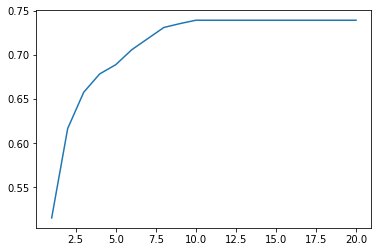

In [16]:
ks = list(range(1, 21))
accuracies = [evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=k) for k in ks]
plt.plot(ks, accuracies)

In [17]:
print(evaluate.mrr(valid_df['ja'].values,
                   tr,
                   k=20))

0.5940395782263255
